In [ ]:
!pip install transformers torch PyPDF2 scikit-learn

In [ ]:
import os
import PyPDF2
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from transformers import AutoTokenizer, AutoModel


In [ ]:
# Load PDFs
pdf_dir = "papers"
pdf_texts = {}
pdf_files = []

print("Loading PDF files...")
for file in os.listdir(pdf_dir):
    if file.endswith(".pdf"):
        try:
            reader = PyPDF2.PdfReader(os.path.join(pdf_dir, file))
            # Extract more text for better classification (first 5 pages)
            text = " ".join([page.extract_text() for page in reader.pages[:5] if page.extract_text()])
            if text.strip():  # Only keep non-empty texts
                pdf_texts[file] = text.strip()
                pdf_files.append(file)
        except Exception as e:
            print(f"Error reading {file}: {e}")

print(f"Successfully loaded {len(pdf_texts)} papers:")
for i, file in enumerate(pdf_files, 1):
    print(f"{i}. {file}")

if len(pdf_texts) < 2:
    print("Error: Need at least 2 papers for clustering!")
    exit()

Loading PDF files...
Successfully loaded 7 papers:
1. $RKVIYGE.pdf
2. $RVUK7M6.pdf
3. $RDRMH1E.pdf
4. $R42YGDC.pdf
5. $RA59B57.pdf
6. $RJI10N2.pdf
7. $R3XVQ9C.pdf


In [ ]:
print("\nInitializing SciBERT model...")
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

def get_embedding(text):
    """Extract SciBERT embedding using CLS token"""
    # Truncate to 512 tokens (SciBERT limit)
    inputs = tokenizer(text[:512], return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Return CLS token embedding (first token)
    return outputs.last_hidden_state[:,0,:].squeeze().numpy()

# Generate embeddings for all papers
print("Generating embeddings...")
embeddings = []
for i, (file, text) in enumerate(pdf_texts.items(), 1):
    print(f"Processing {i}/{len(pdf_texts)}: {file}")
    emb = get_embedding(text)
    embeddings.append(emb)

X_bert = np.array(embeddings)
print(f"Shape of BERT embeddings: {X_bert.shape}")


Initializing SciBERT model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Generating embeddings...
Processing 1/7: $RKVIYGE.pdf
Processing 2/7: $RVUK7M6.pdf
Processing 3/7: $RDRMH1E.pdf
Processing 4/7: $R42YGDC.pdf
Processing 5/7: $RA59B57.pdf
Processing 6/7: $RJI10N2.pdf
Processing 7/7: $R3XVQ9C.pdf
Shape of BERT embeddings: (7, 768)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Find optimal number of clusters using silhouette analysis
print("\nFinding optimal number of clusters...")
silhouette_scores = []
K_range = range(2, min(8, len(pdf_texts)))  # Test 2 to 7 clusters (or max papers-1)

best_score = -1
best_k = 2

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_bert)
    score = silhouette_score(X_bert, cluster_labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"\nOptimal number of clusters: {best_k} (Silhouette Score: {best_score:.4f})")

# Perform final clustering with optimal k
print(f"Performing final clustering with k={best_k}...")
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_bert)

# Create results dataframe
results_df = pd.DataFrame({
    'Paper': pdf_files,
    'Cluster': cluster_labels,
    'Text_Preview': [text[:200] + "..." for text in pdf_texts.values()]
})


Finding optimal number of clusters...
K=2, Silhouette Score: 0.0825
K=3, Silhouette Score: 0.0368
K=4, Silhouette Score: 0.0265
K=5, Silhouette Score: 0.0271
K=6, Silhouette Score: 0.0202

Optimal number of clusters: 2 (Silhouette Score: 0.0825)
Performing final clustering with k=2...


In [ ]:
print("\n" + "="*60)
print("CLUSTERING RESULTS")
print("="*60)

# Show clusters
for cluster_id in range(best_k):
    papers_in_cluster = results_df[results_df['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(papers_in_cluster)} papers):")
    print("-" * 40)
    for idx, row in papers_in_cluster.iterrows():
        print(f"• {row['Paper']}")
        print(f"  Preview: {row['Text_Preview'][:150]}...")
    print()

# Calculate cluster distances to centroid (measure of how "tight" clusters are)
print("Cluster Quality Metrics:")
print("-" * 30)
for cluster_id in range(best_k):
    cluster_points = X_bert[cluster_labels == cluster_id]
    centroid = kmeans_final.cluster_centers_[cluster_id]

    # Calculate average distance to centroid
    distances = [np.linalg.norm(point - centroid) for point in cluster_points]
    avg_distance = np.mean(distances)

    print(f"Cluster {cluster_id}: Avg distance to centroid = {avg_distance:.3f}")


CLUSTERING RESULTS

Cluster 0 (5 papers):
----------------------------------------
• $RKVIYGE.pdf
  Preview: ARTICLE
Promotion or hindrance? Digital transformation of
the supply chain and total factor productivity of
midstream enterprises
Yuqiong Zheng1, Yue ...
• $RVUK7M6.pdf
  Preview: ARTICLE
The role of green ﬁscal stimulus policy in enhancing
the synergistic performance of air pollution control
and carbon mitigation: evidence from...
• $RDRMH1E.pdf
  Preview: ARTICLE
Financial accessibility and environmental
performance: a trade-adjusted analysis of
renewable energy ’s impact in major emerging
markets
Shanw...
• $RJI10N2.pdf
  Preview: ARTICLE
Corporate social responsibility in a non-western
context: the case of the United Arab Emirates
Osman Antwi-Boateng1✉& Noura Eisa Saeed Al Hara...
• $R3XVQ9C.pdf
  Preview: ARTICLE
The effect of childhood experience on consumers ’
willingness to donate: an imprinting perspective
Ying Wang1, Xiaogang He1,2, Qiang Hu1& Ting...


Cluster 1 (2 p


Creating 2D visualization...


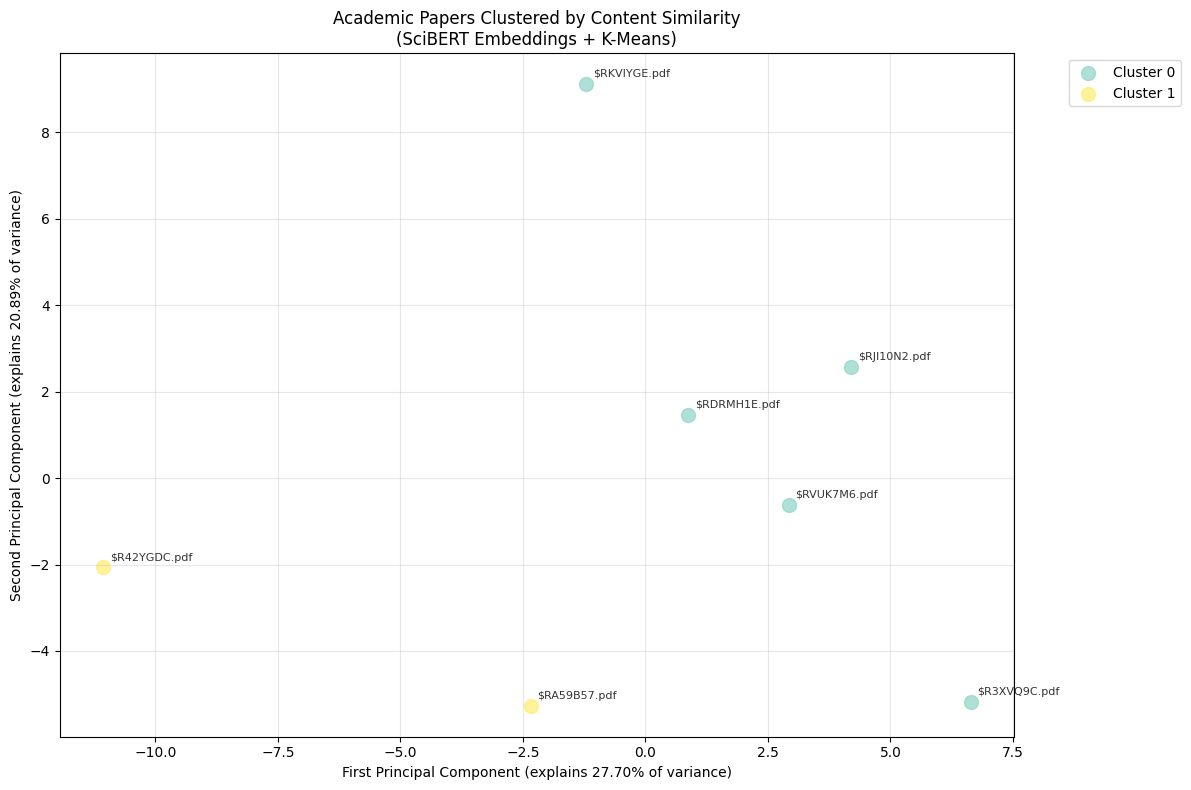

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Visualize clusters in 2D using PCA
print("\nCreating 2D visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_bert)

plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, best_k))

for i in range(best_k):
    mask = cluster_labels == i
    papers_in_cluster = np.array(pdf_files)[mask]

    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=[colors[i]], s=100, alpha=0.7, label=f'Cluster {i}')

    # Add paper names as annotations
    for j, (x, y) in enumerate(X_pca[mask]):
        plt.annotate(papers_in_cluster[j][:15], (x, y),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.8)

plt.title('Academic Papers Clustered by Content Similarity\n(SciBERT Embeddings + K-Means)')
plt.xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.2%} of variance)')
plt.ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.2%} of variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

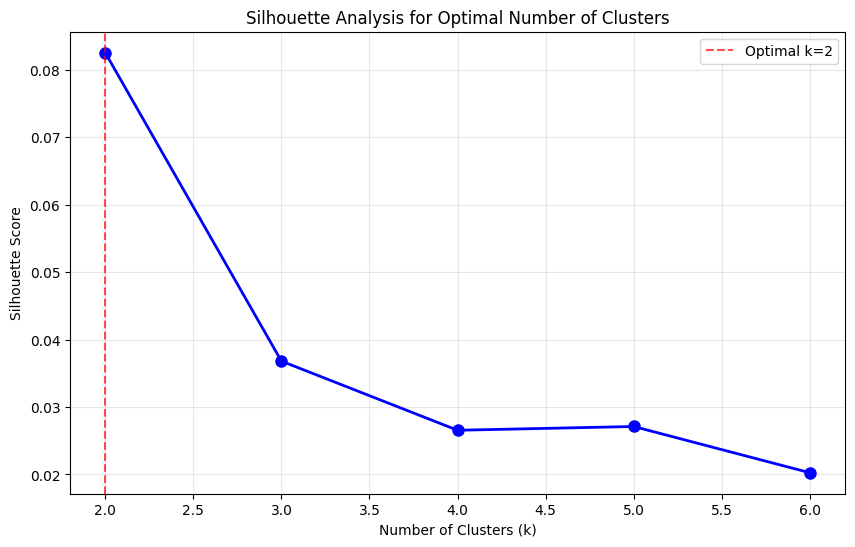

In [ ]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7,
           label=f'Optimal k={best_k}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Number of Clusters')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
# Automatic discipline prediction based on content analysis
print("\n" + "="*60)
print("AUTOMATIC DISCIPLINE PREDICTION")
print("="*60)

# Define discipline keywords for automatic labeling
discipline_keywords = {
    'Computer Science': [
        'algorithm', 'machine learning', 'neural network', 'artificial intelligence',
        'software', 'programming', 'database', 'computer', 'computing', 'data structure',
        'deep learning', 'python', 'java', 'optimization', 'classification', 'regression',
        'CNN', 'RNN', 'transformer', 'GPU', 'API', 'framework', 'model', 'training',
        'feature', 'dataset', 'accuracy', 'performance', 'computational'
    ],
    'Social Science': [
        'society', 'social', 'behavior', 'psychology', 'sociology', 'anthropology',
        'culture', 'demographic', 'survey', 'interview', 'qualitative', 'quantitative',
        'participant', 'human', 'community', 'policy', 'government', 'political',
        'economic', 'education', 'healthcare', 'welfare', 'public', 'social network'
    ],
    'Natural Science': [
        'experiment', 'hypothesis', 'theory', 'scientific', 'analysis',
        'biology', 'chemistry', 'physics', 'genetics', 'molecule', 'cell', 'protein',
        'gene', 'species', 'evolution', 'laboratory', 'specimen', 'observation',
        'biochemical', 'molecular', 'organic', 'inorganic', 'catalyst', 'reaction'
    ],
    'Mathematics': [
        'theorem', 'proof', 'equation', 'formula', 'mathematical', 'function',
        'matrix', 'vector', 'calculus', 'statistics', 'probability', 'geometry',
        'algebra', 'topology', 'derivative', 'integral', 'optimization', 'numerical',
        'discrete', 'continuous', 'linear', 'nonlinear', 'convergence'
    ],
    'Engineering': [
        'design', 'system', 'engineering', 'mechanical', 'electrical', 'civil',
        'material', 'structure', 'process', 'manufacturing', 'control', 'signal',
        'circuit', 'sensor', 'actuator', 'robotics', 'automation', 'simulation',
        'prototype', 'testing', 'validation', 'efficiency', 'performance'
    ],
    'Medicine/Health': [
        'patient', 'clinical', 'medical', 'health', 'disease', 'treatment', 'therapy',
        'diagnosis', 'hospital', 'healthcare', 'pharmaceutical', 'drug', 'medicine',
        'symptom', 'pathology', 'epidemiology', 'surgery', 'nursing', 'rehabilitation'
    ]
}




AUTOMATIC DISCIPLINE PREDICTION


In [ ]:
def predict_discipline_from_text(text):
    """Predict discipline based on keyword frequency"""
    text_lower = text.lower()
    scores = {}

    for discipline, keywords in discipline_keywords.items():
        # Count keyword occurrences
        keyword_count = sum(text_lower.count(keyword) for keyword in keywords)
        # Normalize by text length and number of keywords
        normalized_score = keyword_count / (len(text.split()) * len(keywords)) * 1000
        scores[discipline] = normalized_score

    # Return discipline with highest score
    if max(scores.values()) > 0:
        best_discipline = max(scores.items(), key=lambda x: x[1])
        return best_discipline[0], best_discipline[1]
    else:
        return "Unknown", 0.0

# Predict disciplines for all papers
paper_predictions = []
for file, text in pdf_texts.items():
    predicted_discipline, confidence = predict_discipline_from_text(text)
    paper_predictions.append({
        'Paper': file,
        'Predicted_Discipline': predicted_discipline,
        'Confidence_Score': confidence
    })

# Add predictions to results dataframe
prediction_df = pd.DataFrame(paper_predictions)
results_with_predictions = results_df.merge(prediction_df, on='Paper')

print("Individual Paper Predictions:")
print("-" * 50)
for _, row in results_with_predictions.iterrows():
    print(f"Paper: {row['Paper']}")
    print(f"  Predicted Discipline: {row['Predicted_Discipline']}")
    print(f"  Confidence Score: {row['Confidence_Score']:.4f}")
    print(f"  Assigned Cluster: {row['Cluster']}")
    print()

# Analyze cluster composition by predicted disciplines
print("Cluster Analysis by Predicted Disciplines:")
print("-" * 50)
for cluster_id in range(best_k):
    cluster_papers = results_with_predictions[results_with_predictions['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_papers)} papers):")

    # Count disciplines in this cluster
    discipline_counts = cluster_papers['Predicted_Discipline'].value_counts()
    for discipline, count in discipline_counts.items():
        percentage = (count / len(cluster_papers)) * 100
        print(f"  {discipline}: {count} papers ({percentage:.1f}%)")

    # Suggest cluster label based on majority
    if len(discipline_counts) > 0:
        majority_discipline = discipline_counts.index[0]
        majority_percentage = (discipline_counts.iloc[0] / len(cluster_papers)) * 100
        print(f"  → Suggested cluster label: {majority_discipline} ({majority_percentage:.1f}% majority)")

# Create final classification model
cluster_to_discipline = {}
for cluster_id in range(best_k):
    cluster_papers = results_with_predictions[results_with_predictions['Cluster'] == cluster_id]
    if len(cluster_papers) > 0:
        # Assign discipline based on majority vote in cluster
        majority_discipline = cluster_papers['Predicted_Discipline'].value_counts().index[0]
        cluster_to_discipline[cluster_id] = majority_discipline
    else:
        cluster_to_discipline[cluster_id] = "Unknown"

print(f"\nFinal Cluster-to-Discipline Mapping:")
print("-" * 40)
for cluster_id, discipline in cluster_to_discipline.items():
    print(f"Cluster {cluster_id} → {discipline}")

# Add final predictions to dataframe
results_with_predictions['Final_Predicted_Discipline'] = results_with_predictions['Cluster'].map(cluster_to_discipline)

Individual Paper Predictions:
--------------------------------------------------
Paper: $RKVIYGE.pdf
  Predicted Discipline: Social Science
  Confidence Score: 0.3436
  Assigned Cluster: 0

Paper: $RVUK7M6.pdf
  Predicted Discipline: Social Science
  Confidence Score: 0.8900
  Assigned Cluster: 0

Paper: $RDRMH1E.pdf
  Predicted Discipline: Social Science
  Confidence Score: 0.4721
  Assigned Cluster: 0

Paper: $R42YGDC.pdf
  Predicted Discipline: Computer Science
  Confidence Score: 0.8105
  Assigned Cluster: 1

Paper: $RA59B57.pdf
  Predicted Discipline: Computer Science
  Confidence Score: 1.5153
  Assigned Cluster: 1

Paper: $RJI10N2.pdf
  Predicted Discipline: Social Science
  Confidence Score: 1.5308
  Assigned Cluster: 0

Paper: $R3XVQ9C.pdf
  Predicted Discipline: Social Science
  Confidence Score: 1.7177
  Assigned Cluster: 0

Cluster Analysis by Predicted Disciplines:
--------------------------------------------------

Cluster 0 (5 papers):
  Social Science: 5 papers (100.0%)

In [ ]:
print(f"\nFinal Classification Results:")
print("=" * 60)
print(f"{'Paper':<30} {'Cluster':<8} {'Final Discipline':<20}")
print("-" * 60)
for _, row in results_with_predictions.iterrows():
    paper_name = row['Paper'][:28] + ".." if len(row['Paper']) > 30 else row['Paper']
    print(f"{paper_name:<30} {row['Cluster']:<8} {row['Final_Predicted_Discipline']:<20}")


Final Classification Results:
Paper                          Cluster  Final Discipline    
------------------------------------------------------------
$RKVIYGE.pdf                   0        Social Science      
$RVUK7M6.pdf                   0        Social Science      
$RDRMH1E.pdf                   0        Social Science      
$R42YGDC.pdf                   1        Computer Science    
$RA59B57.pdf                   1        Computer Science    
$RJI10N2.pdf                   0        Social Science      
$R3XVQ9C.pdf                   0        Social Science      


In [ ]:
import joblib
import json

# 1. Save KMeans model
joblib.dump(kmeans_final, "exported_models/kmeans_model.pkl")
print("Saved KMeans model to exported_models/kmeans_model.pkl")

# 2. Save cluster-to-discipline mapping
with open("exported_models/cluster_to_discipline.json", "w") as f:
    json.dump(cluster_to_discipline, f, indent=2)
print("Saved cluster-to-discipline mapping to exported_models/cluster_to_discipline.json")

joblib.dump(vectorizer, 'exported_models/vectorizer.pkl')


Saved KMeans model to exported_models/kmeans_model.pkl
Saved cluster-to-discipline mapping to exported_models/cluster_to_discipline.json


NameError: name 'vectorizer' is not defined